## OtoWorld
Welcome to OtoWorld, an interactive environment where agents must learn to listen in order to solve navigational tasks. 

OtoWorld can be easily extended to more complex environments and games. To solve one episode of OtoWorld, an agent must move towards each sounding source in the auditory scene and 'turn it off'. The agent receives no other input other than the current sound of the room. The sources are placed randomly within the room and can vary in number. The agent receives a reward for turning off a source.

### This Tutorial will Cover the Following Topics:
- How to Install OtoWorld
- Environment Overview
- Environment Creation
- Agent Creation
- Oracle Agent Walkthrough

### How to get Started
There are six steps that need to be taken in order to properly install OtoWorld and its dependencies. 
1. Clone the repository

```git clone https://github.com/pseeth/otoworld.git```

2. Create a conda environment to install all OtoWorld dependencies.

```conda env create -n otoworld && conda activate otoworld```

3. Install OtoWorld requirements into the conda environment. 

```pip install -r requirements.txt```

4. Install ffmpeg from conda distribution (Note: Pypi distribution of ffmpeg is outdated).

```conda install ffmpeg```

5. Install Pytorch 1.3 or 1.4 from official source.

```pip install torch==1.3.0+cu100 torchvision==0.4.1+cu100 -f https://download.pytorch.org/whl/torch_stable.html```

#### Additional Notes
Linux users may need to install the sound file library if it is not present in the system. It can be done using the following command.
```sudo apt-get install libsndfile1```
This should take care of a common ```musdb``` error.

### Environment Overview
A tldr of OtoWorld is a game where audio sources are placed randomly in a room with the objective of coming close enough to the audio such that we can turn it off. Everytime we turn off an audio source, we are rewarded. Once we turn off all audio sources, the game has been won. OtoWorld is built on three open source libraries: OpenAI Gym for environment and agent interaction, Pyroomacoustics for ray-tracing and acoustics simulation, and nussl for training deep computer audition models.

In order to better understand the workflow and enviroment configurations, we recommend reading over the descriptions of the following packages/files. 

- ```audio_room```

This is the package that holds all the source code for the gym environment. All of the various environment configurations can be found here. This includes the room configurations (size, materials, absorption rates), number of audio sources, step size, threshold radius, number of channels and more.

- ```agent.py```

This file contains the agents, including an Oracle and random agent, which will be used to navigate a room. We recommend that you follow a similar code structure to the pre-defined agents. The reason why is because our code makes it convient for users to build agents and save their models. In order to build an valid agent, only four functions must be implemented (which is discussed below).

- ```constants.py```

This file contains some of the parameters used to penalize/reward an agent, build a trainable dataset and more. 

- ```datasets.py```

This file contains the source code responsible for building a dataset by capturing the state information, rewards, and actions.

- ```utils.py```

This file contains utility functions that make the OtoWorld workflow simplier. This includes functions that help randomly select audio files, visualize how well and quickly the agent is learning, and more.

- ```room_types.py```

This file allows you to create simple polygon and shoebox rooms.

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import gym
import numpy as np

import sys
sys.path.append("../src")

import warnings
warnings.filterwarnings('ignore')

from agent import OracleAgent
import audio_room
import constants
from datasets import BufferData
import nussl
import room_types
import utils

nussl.utils.seed(42)

INFO:root:

------------------------------ 
- Starting to Fit Agent
------------------------------- 




### Environment Creation
Creating an environment requires gym since audio_room is built on top of OpenAI Gym. As mentioned above, the configurable parameters for an environment can be found in audio_env.py. A few of the more important parameters are listed below:
- room_config (List or np.array): dimensions of the room. For Shoebox, in the form of [10,10]. Otherwise,
    in the form of [[1,1], [1, 4], [4, 4], [4, 1]] specifying the corners of the room
- step_size (float): step size used to move forward/backward. Defaults to 1.
- acceptable_radius (float): source is considered found/turned off if agent is within this distance of src
- num_sources (int): the number of audio sources the agent will listen to
- degrees (float): value of degrees to rotate in radians (.2618 radians = 15 degrees)
- source_folders_dict (Dict[str, int]): specify how many source files to choose from each folder
                e.g.
                    {
                        'car_horn_source_folder': 1,
                        'phone_ringing_source_folder': 1
                    }

#### Room Creation
Rooms are created using the Pyroomacoustics library. Users can create simple Shoebox (rectangular) room or create more complicated n-shaped polygon rooms. Through Pyroomacoustics, the environment supports the creation of rooms with different wall materials, energy absorption rates, temperatures, and humidity. You can create rooms either by importing room_types or by directly using the Pyroomacoustics library.

In [2]:
# We want to randomly select one female and one male audio sample every episode
source_folders_dict = {"../sounds/samples/female" : 1, "../sounds/samples/male" : 1}

# Create a square 5x5 room using room_types
square_room = room_types.ShoeBox(x_length=4, y_length=4)

# Set up the gym environment
env = gym.make(
    "audio-room-v0",
    source_folders_dict=source_folders_dict,
    room_config=square_room.generate(),
    corners=square_room.corners,
    max_order=10,
    step_size=1.0,
    num_sources=2,
    acceptable_radius=1.0,
    reset_sources=False,
    same_config=True
)
env.seed(42)

Source locs [[3.209240790978062, 3.094466488558782], [1.9999999999999996, 0.4402898233418924]]
Placing agent at [0.027808522124762813, 2.042989210310263]


### Agent Creation
In order to create your own navigational agent, you must create a subclass of the AgentBase class found in the src/agent.py. There are four functions that must be implemented.
1. ```choose_action()```
This function will decide what action you take from the action space given the current state.
2. ```update()```
This function will update the q-network.
3. ```update_stable_network()```
This function will update the stable network.
4. ```save_model()```
This function periodically will save whatever parameters you find to be valuable i.e. it saves the model

Once these functions are implemented, call agent.fit() to start an experiment.


NOTE: Since this is a perfect agent, it is necessary to make epsilon 0 since we know what action we need to take. In order to change epsilon, all we need to do is update the ```MAX_EPSILON``` and ```MIN_EPSILON``` constants in constants.py to 0.

#### Logging Information and Building a Trainable Dataset
Once we create a room to navigate, we have to create a buffer folder in order to build a dataset. We can do this by calling the utils create_buffer_data_folders() function. This function will create three folders that store the dataset items, states and previous states. The path to the dataset folder is defined and configurable in constants.py.

In [3]:
# Using utils. to
utils.create_buffer_data_folders()
dataset = BufferData(folder=constants.DIR_DATASET_ITEMS, to_disk=False)

agent = OracleAgent(env, dataset, show_room=True, play_audio=True, max_steps=100)

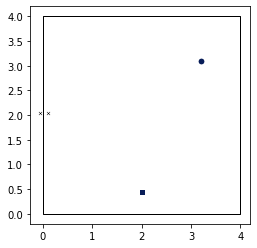

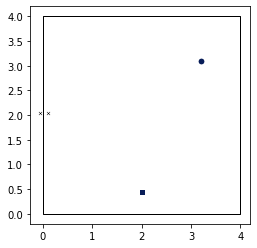

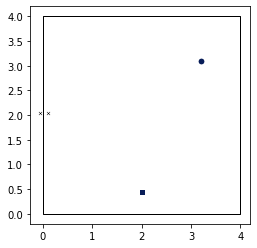

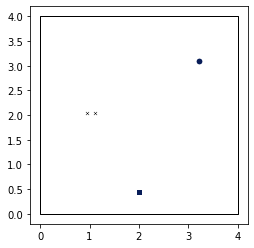

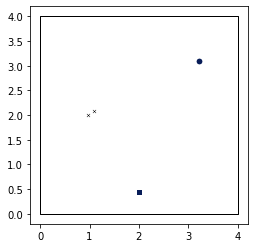

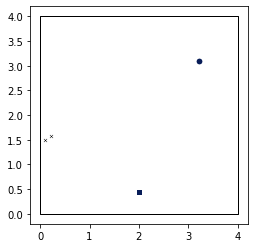

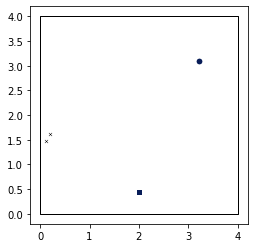

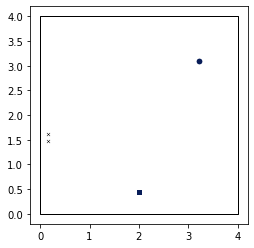

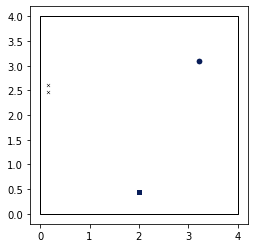

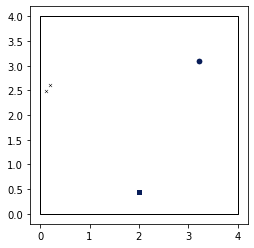

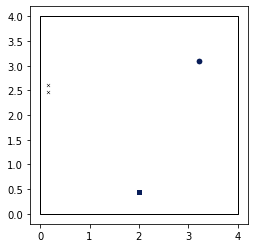

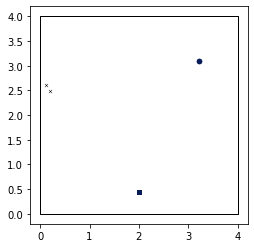

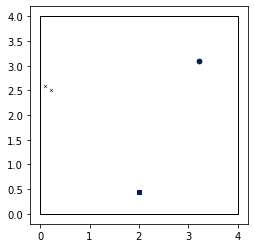

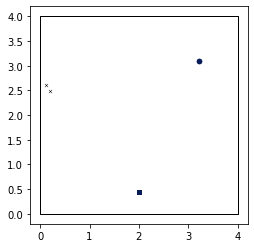

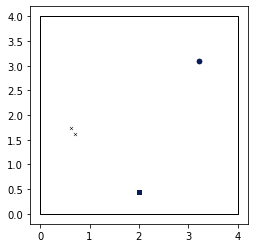

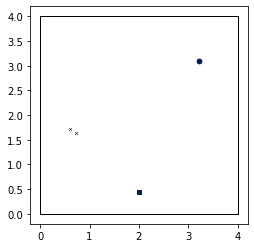

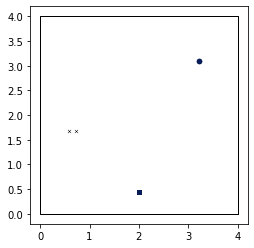

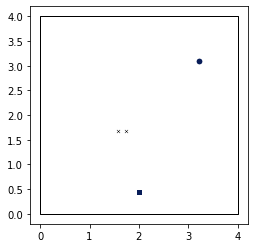

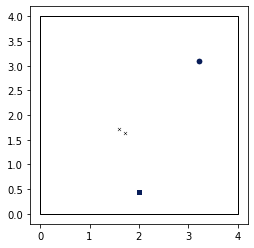

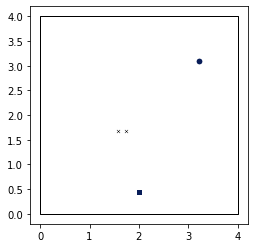

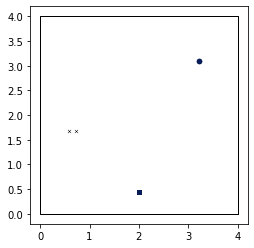

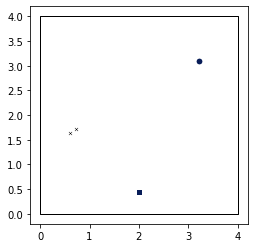

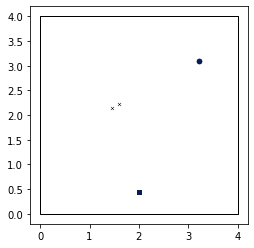

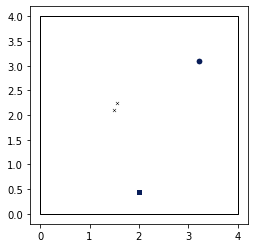

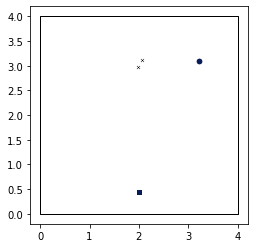

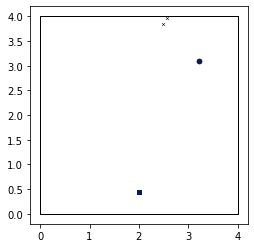

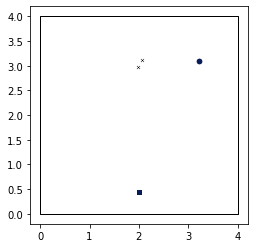

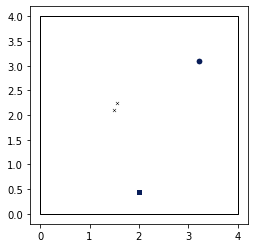

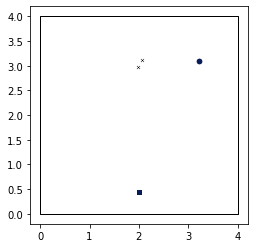

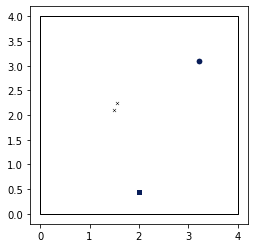

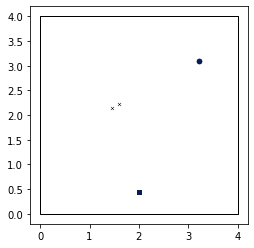

Agent has found source ../sounds/samples/female/050a050c.wav. 
Agent loc: [2.39382654 2.67698004], Source loc: [3.209240790978062, 3.094466488558782]


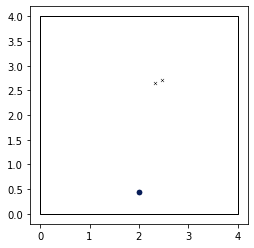

INFO:root:In FIT. Received reward 99.5 at step: 31



In FIT. Received reward: 99.5 at step 31



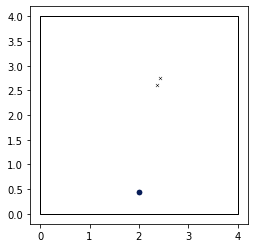

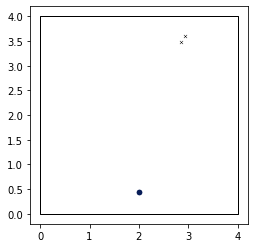

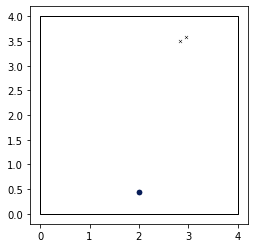

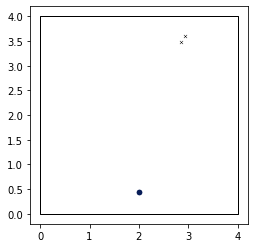

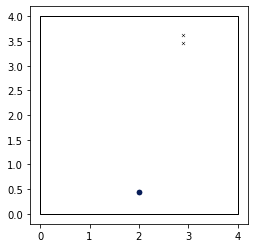

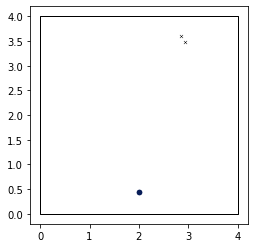

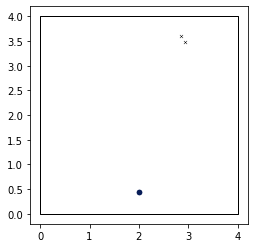

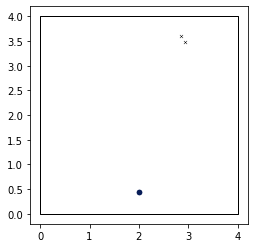

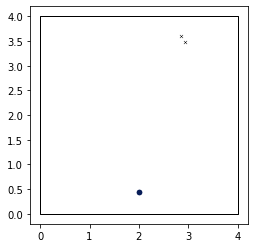

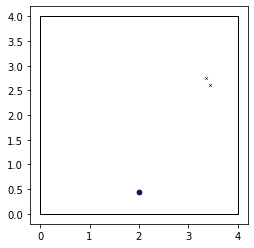

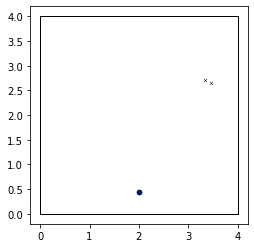

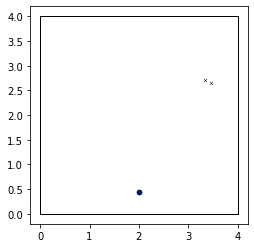

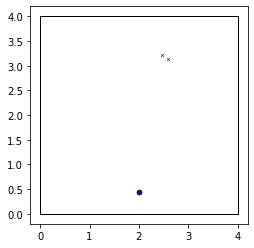

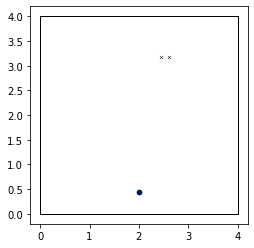

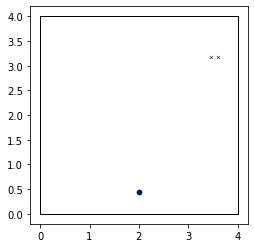

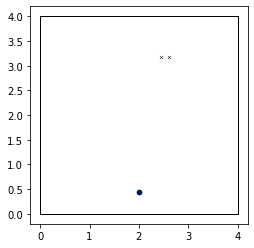

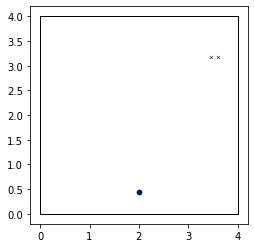

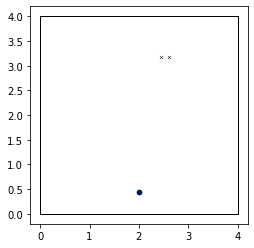

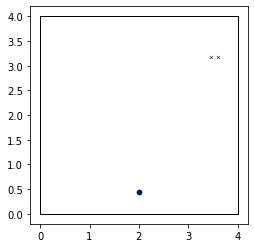

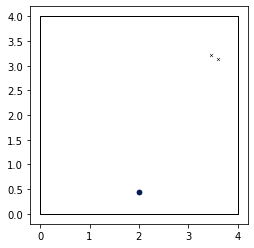

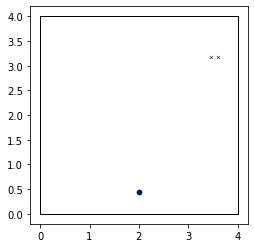

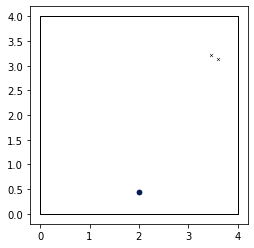

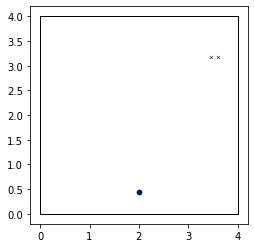

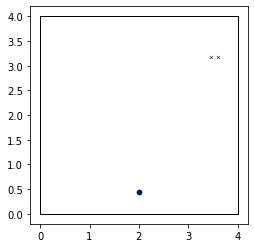

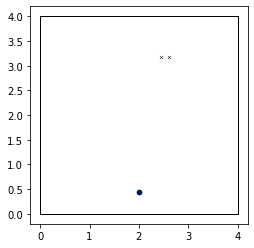

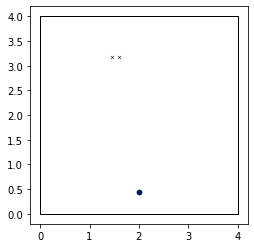

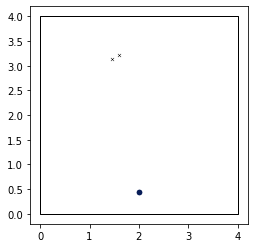

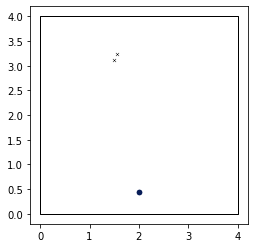

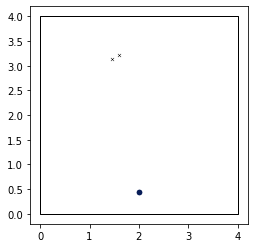

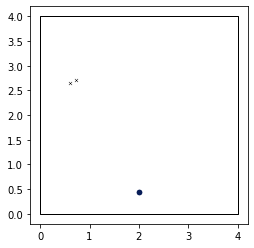

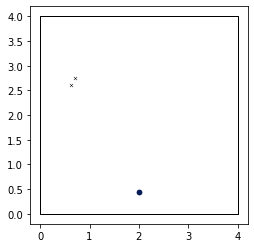

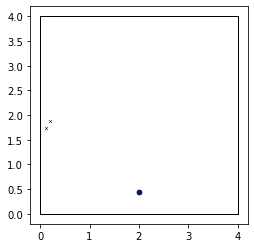

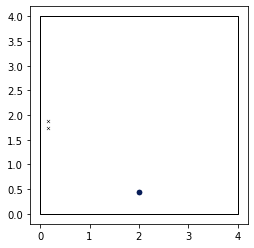

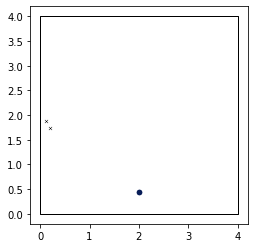

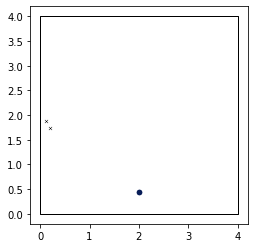

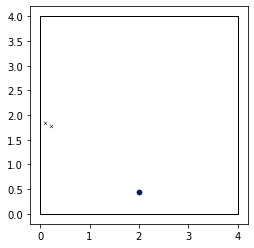

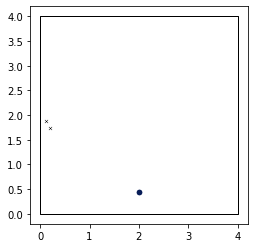

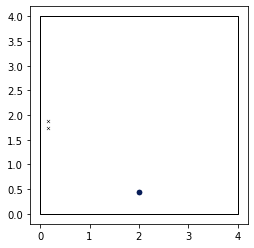

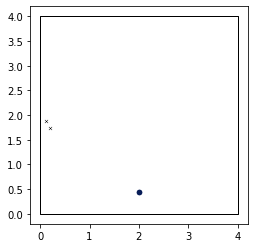

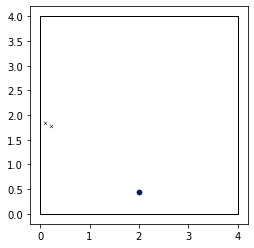

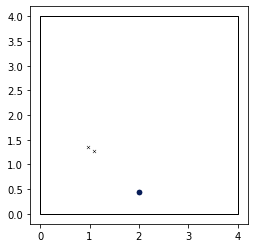

INFO:root:In FIT. Received reward 99.5 at step: 73

INFO:root:

Episode Summary 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
- Episode: 1
- Won?: True
- Finished at step: 74
- Time taken:   128.154169 
- Steps/Second: 0.577430 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 



Agent has found source ../sounds/samples/male/051a050b.wav. 
Agent loc: [1.89383078 0.81096231], Source loc: [1.9999999999999996, 0.4402898233418924]
Source locs [[3.209240790978062, 3.094466488558782], [1.9999999999999996, 0.4402898233418924]]
Placing agent at [0.027808522124762813, 2.042989210310263]
In FIT. Received reward: 99.5 at step 73



Episode Summary 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
- Episode: 1
- Won?: True
- Finished at step: 74
- Time taken:   128.154169 
- Steps/Second: 0.577430 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 

Source locs [[3.209240790978062, 3.094466488558782], [1.9999999999999996, 0.4402898233418924]]
Placing agent at [0.027808522124762813, 2.042989210310263]


In [4]:
agent.fit()

### Accessing Logging Information

### Accessing the Dataset

### Adjusting the Difficulty of OtoWorld
There are numerous ways we can adjust the 
- Number of audio sources
- room configurations (size, materials, absorption)
- step sizes and rotation

### Extending OtoWorld
- 3d games
- hide and seek
- moving audio sources 
- multi-speaker speech recognition, music transcription, and sound event detection (copied from the reviewers)
- Will a model in one room work on a different configured room (taken from the reviewers)

### OtoWorld Paper
- https://openreview.net/pdf?id=lzZGXUpV78X